In [348]:
#1.Gerekli kütüphaneler 
# matematiksel işlemler icin
import pandas as pd
import numpy as np

# Görselleştirme Kütüphaneleri
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import seaborn as sns
import warnings

# Model ve Ön İşleme Kütüphaneleri
from sklearn.preprocessing import StandardScaler #Veri ölçeklendirme için
from sklearn.model_selection import GridSearchCV, train_test_split #Model doğrulama ve veri bölme için
from sklearn.linear_model import ElasticNet, SGDRegressor #Kullanılacak modeller icin
from sklearn.feature_selection import SequentialFeatureSelector #Sıralı özellik seçimi (SFS) için
from sklearn.decomposition import PCA #Temel bileşenler analizi (PCA) için
from sklearn.metrics import mean_squared_error, r2_score #Model başarı metrikleri

warnings.filterwarnings('ignore') #Kodun çıktısını temiz tutmak için uyarıları kapatıyorum
plt.style.use('seaborn-v0_8-darkgrid') #Grafikler için tema ayarı

print(" Tüm Gerekli Kütüphaneler Başarıyla Yüklendi ve Ortam Ayarları Yapıldı.")

 Tüm Gerekli Kütüphaneler Başarıyla Yüklendi ve Ortam Ayarları Yapıldı.


In [349]:
#2.veri yukleme 
import pandas as pd
from IPython.display import display

#Dosyadan veriyi okuma
df = pd.read_csv(r'C:\Users\islam-pc\Downloads\XAU_15m_data_2004_to_2024-20-09.csv.zip')

print(" Veri Set Bilgisi:")
# Verinin boyutunu (satır x sütun) göstermek için
print(f" Verinin boyutu (satır × sütun): {df.shape}")

# İlk 5 satırı gösterir sadece veri yapısını anlamamız için
print(" Verinin ilk 5 satırı")
display(df.head())

 Veri Set Bilgisi:
 Verinin boyutu (satır × sütun): (464737, 7)
 Verinin ilk 5 satırı


,Date,Time,Open,High,Low,Close,Volume
0,2004.06.11,07:15,384.0,384.3,383.8,384.3,12
1,2004.06.11,07:30,383.8,384.3,383.6,383.8,12
2,2004.06.11,07:45,383.3,383.8,383.3,383.8,20
3,2004.06.11,08:00,383.8,384.1,383.6,383.6,8
4,2004.06.11,08:15,383.6,384.3,383.5,383.5,20


In [350]:
# tarih sütununu datetime tipine çevirme (temizlik için gerekli)
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# veriyi tarih sırasına göre sıralama
df = df.sort_values(by="Date")

# eksik değer kontrolü
missing_values = df.isnull().sum()
print("\n eksik değer sayısı:")
print(missing_values)
# tarih sütununu indeks yapma (zaman serisi analizleri için gerekli)
if 'Date' in df.columns:
    df = df.set_index('Date')
    
print("\nTemizlik öncesi eksik değerler:") 
print(missing_values)


 eksik değer sayısı:
Date      0
Time      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Temizlik öncesi eksik değerler:
Date      0
Time      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [351]:
#Aykırı değer tespiti
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f" {col} (IQR): Aykırı değer sayısı = {len(outliers)}")
#tarih sütununu indeks yapıyoruz (Zaman serisi analizleri ve Feature Engineering için)
if 'Date' in df.columns:
    df = df.set_index('Date')

 Open (IQR): Aykırı değer sayısı = 0
 High (IQR): Aykırı değer sayısı = 0
 Low (IQR): Aykırı değer sayısı = 0
 Close (IQR): Aykırı değer sayısı = 0
 Volume (IQR): Aykırı değer sayısı = 24330


In [352]:
#3.Feature engıneerıng
#1.zamansal Özellikler
#fiyatın zaman dilimine göre davranışını yakalamak için
y = df['Close']
X = df.drop('Close', axis=1) # Close hariç tüm sütunlar özellik olmalı
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day
df['Hour'] = df.index.hour
df['Weekday'] = df.index.weekday #0= Pazartesi 6= Pazar Haftalık döngüyü yakalamak için

In [353]:
#2.Temel fiyat farkları (Price Spreads)
# boyutu ve yönü temsil eden özellikler
df['High_Low_Diff'] = df['High'] - df['Low'] #toplam genişliği 
df['Close_Open_Diff'] = df['Close'] - df['Open'] #yönü (Pozitif: Yükseliş, Negatif: Düşüş)
df['High_Close_Diff'] = df['High'] - df['Close'] #kapanışın gün içi en yüksekten farkı
df['Low_Close_Diff'] = df['Low'] - df['Close'] #kapanışın gün içi en düşükten farkı

In [354]:
#3.Hareketli ortalama ve standart sapma (Rolling / Moving Average - MA ve STD)
#trend ve volatiliteyi kısa orta ve uzun vadede yakalamak için
for w in [3, 5, 10]: # 3, 5 ve 10 periyotluk pencereler kullanıyoruz
    df[f'MA_Close_{w}'] = df['Close'].rolling(window=w).mean() #kapanış hareketli ortalaması (Trend)
    df[f'STD_Close_{w}'] = df['Close'].rolling(window=w).std()  #kapanış standart sapması (Volatilite)
    df[f'MA_High_{w}'] = df['High'].rolling(window=w).mean()
    df[f'MA_Low_{w}'] = df['Low'].rolling(window=w).mean()

In [355]:
#4.Gecikmeli Özellikler (Lag Features)
#Önceki periyotlardaki fiyatın tahmin üzerindeki etkisini modellemek için
df['Close_Lag1'] = df['Close'].shift(1) #bir önceki periyot kapanış
df['Close_Lag2'] = df['Close'].shift(2) 
df['Close_Lag3'] = df['Close'].shift(3)

In [356]:
#5.Momentum Özelliği
#Fiyat değişim hızını yakalamak için
df['Momentum_1'] = df['Close'] - df['Close_Lag1'] #en son fiyattan bir önceki farkı
df['Momentum_2'] = df['Close'] - df['Close_Lag2'] #en son fiyattan iki önceki farkı

In [357]:
# Lag ve Rolling/MA hesaplamalarından kaynaklanan ilk NaN (Not a Number) değerleri siliyor
df.dropna(inplace=True)
print("Özellik Mühendisliği Başlatılıyor...")
print(f" Özellik Mühendisliği Tamamlandı. Toplam özellik sayısı: {df.shape[1]}")
print("Son Durumdaki Verinin İlk 10 Satırı:")
display(df.head(10))

Özellik Mühendisliği Başlatılıyor...
 Özellik Mühendisliği Tamamlandı. Toplam özellik sayısı: 32
Son Durumdaki Verinin İlk 10 Satırı:


,Time,Open,High,Low,Close,Volume,Year,Month,Day,Hour,...,MA_Low_5,MA_Close_10,STD_Close_10,MA_High_10,MA_Low_10,Close_Lag1,Close_Lag2,Close_Lag3,Momentum_1,Momentum_2
Date,,,,,,,,,,,,,,,,,,,,,
2004-06-11,13:00,383.6,383.6,383.6,383.6,3,2004,6,11,0,...,383.98,384.03,0.323351,384.06,383.87,384.6,384.3,383.8,-1.0,-0.7
2004-06-11,16:00,384.3,384.3,384.3,384.3,1,2004,6,11,0,...,384.08,384.03,0.323351,384.06,383.92,383.6,384.6,384.3,0.7,-0.3
2004-06-11,16:30,384.3,384.3,384.1,384.3,6,2004,6,11,0,...,384.14,384.08,0.322490,384.11,383.97,384.3,383.6,384.6,0.0,0.7
2004-06-11,16:45,384.3,384.3,384.1,384.3,7,2004,6,11,0,...,384.14,384.08,0.322490,384.11,384.02,384.3,384.3,383.6,0.0,0.0
2004-06-11,17:00,384.1,384.1,384.1,384.1,1,2004,6,11,0,...,384.04,384.09,0.321282,384.09,384.03,384.3,384.3,384.3,-0.2,-0.2
2004-06-11,17:15,384.1,384.1,384.1,384.1,2,2004,6,11,0,...,384.14,384.12,0.304777,384.12,384.06,384.1,384.3,384.3,0.0,-0.2
2004-06-11,17:30,384.3,384.3,384.1,384.1,2,2004,6,11,0,...,384.10,384.15,0.283823,384.17,384.09,384.1,384.1,384.3,0.0,0.0
2004-06-11,17:45,383.8,383.8,383.8,383.8,1,2004,6,11,0,...,384.04,384.15,0.283823,384.17,384.09,384.1,384.1,384.1,-0.3,-0.3
2004-06-11,18:30,384.3,384.3,384.3,384.3,2,2004,6,11,0,...,384.08,384.15,0.283823,384.17,384.11,383.8,384.1,384.1,0.5,0.2


Altın Fiyatı Zaman Serisi Görselleştirmesi:


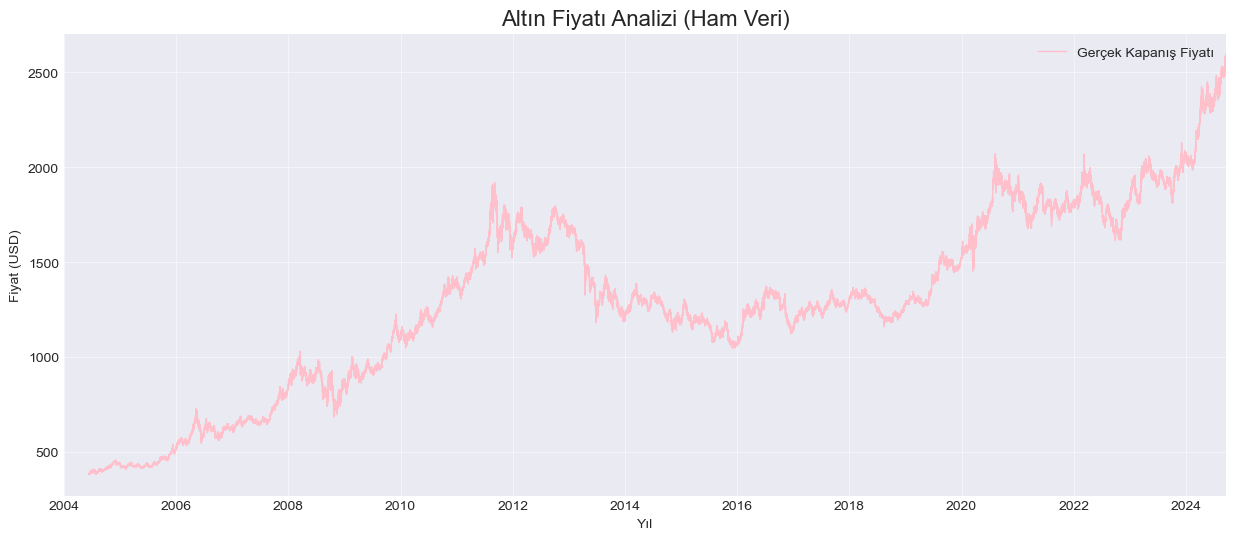

In [358]:
#4.Veri analiz
print("Altın Fiyatı Zaman Serisi Görselleştirmesi:")

plt.figure(figsize=(15, 6))
# Tüm zaman serisini çiziyoru
plt.plot(df.index, df['Close'], color='pink', linewidth=1, label='Gerçek Kapanış Fiyatı')

# X eksenini daha okunaklı yapmak için 2 yıllık aralıklarla etiketleme
plt.xlim(pd.Timestamp('2004-01-01'), df.index.max()) # Belirli bir başlangıçtan en sona kadar
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title("Altın Fiyatı Analizi (Ham Veri)", fontsize=16)
plt.xlabel("Yıl")
plt.ylabel("Fiyat (USD)")
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

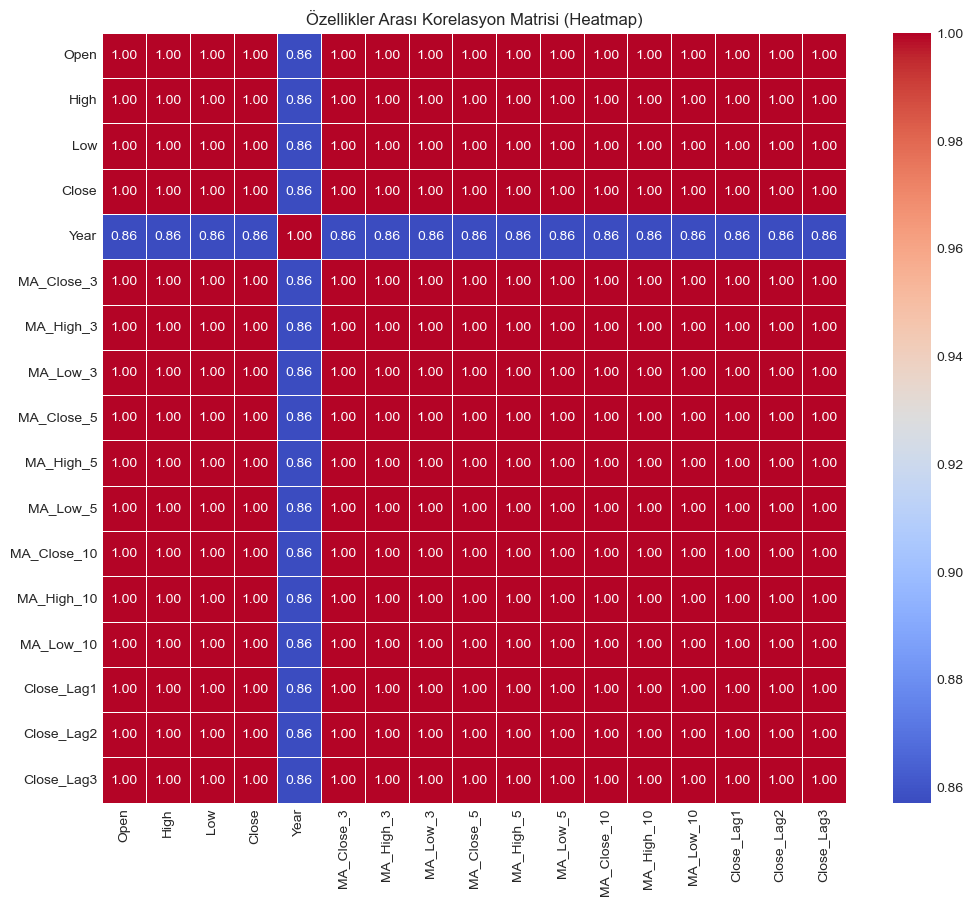

In [359]:
#Korelasyon matrisi
import seaborn as sns
import matplotlib.pyplot as plt

# Sadece sayısal sütunları alalım
numerical_df = df.select_dtypes(include=[np.number])

# Korelasyon hesapla
corr_matrix = numerical_df.corr()

# Hedef değişken (Close) ile en yüksek korelasyona sahip 10 özelliği bul
top_corr_features = corr_matrix.index[abs(corr_matrix["Close"]) > 0.5]

plt.figure(figsize=(12, 10))
plt.title("Özellikler Arası Korelasyon Matrisi (Heatmap)")
# Sadece en ilişkili özellikleri çizelim ki grafik karışmasın
sns.heatmap(df[top_corr_features].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.show()

In [360]:
#5.Veriyi %80 eğitim %20 test olarak bölüm
#zaman serisi verileri için karıştırmadan bölme
X_train_shuffle, X_test_shuffle, y_train_shuffle, y_test_shuffle = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42 )

# Ölçeklendirme (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Son durumu gösterme
print("Veriler modeller için hazır:")
print(f"X_train: {X_train_scaled.shape}, X_test: {X_test_scaled.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

Veriler modeller için hazır:
X_train: (371782, 30), X_test: (92946, 30)
y_train: (371782,), y_test: (92946,)


In [361]:
#6.sıralı özellik seçimi (sequential feature selector - sfs)
print("SFS Başlıyor en iyi 5 özellik seçiliyor")

#Hız için SFS'yi tüm eğitim verisi yerine rastgele seçilmiş bir alt kümede çalıştırıyorum
idx = np.random.choice(X_train_scaled_df.shape[0], 5000, replace=False)
X_train_subset = X_train_scaled_df.iloc[idx]
y_train_subset = y_train.iloc[idx]

SFS Başlıyor en iyi 5 özellik seçiliyor


In [362]:
#Tahmincisini temel alarak SFS oluşturuyor
sfs = SequentialFeatureSelector(
    ElasticNet(alpha=0.1, l1_ratio=0.9, random_state=42, max_iter=2000), #Kullanılacak model
    n_features_to_select=5,             # Sadece 5 özellik seçmek istiyorum
    direction='forward',                # "İleri" seçim: En iyiden başlayıp birer birer ekleme
    cv=3,                               # 3 katlı çapraz doğrulama
    n_jobs=-1,                          # Tüm çekirdekleri kullan
    scoring='neg_root_mean_squared_error' # RMSE'yi minimize etmek için (negatif skor maximize edilir)
)

In [363]:
#Alt örneklenmiş veri üzerinde fit işlemi
sfs.fit(X_train_subset, y_train_subset)

#Seçilen özellikleri görüntüleme
selected_features_sfs = list(X_train_scaled_df.columns[sfs.get_support()])
print(f" Seçilen 5 En İyi Özellik: {selected_features_sfs}")

 Seçilen 5 En İyi Özellik: ['Open', 'High', 'Low', 'Close_Open_Diff', 'MA_Close_3']


In [364]:
# X_train ve X_test'i seçilen 5 özellik alt kümesine indirgeme (model eğitimi için)
X_train_sfs = X_train_scaled_df[selected_features_sfs].values
X_test_sfs = X_test_scaled_df[selected_features_sfs].values
print("SFS Başlıyor: en iyi 5 özellik seçiliyor")
print(f"SFS ile özellik seçimi tamamlandı. Yeni boyut: {X_train_sfs.shape}")

SFS Başlıyor: en iyi 5 özellik seçiliyor
SFS ile özellik seçimi tamamlandı. Yeni boyut: (371782, 5)


In [365]:
#6:Temel bileşenler analizi (principal component analysis - pca)
print("PCA Başlıyor: Varyansın %99'unu koruyacak bileşen sayısına indirgeme yapılıyor...")

#n_components=0.99 ayarı: Toplam varyansın %99'unu koruyacak minimum bileşen sayısını otomatik seçer.
pca = PCA(n_components=0.99)

#PCA dönüşümü fit_transform sadece X_train_scaled_df üzerinde yapılır
X_train_pca = pca.fit_transform(X_train_scaled_df)
#Test verisi üzerinde sadece dönüştürme yapılır
X_test_pca = pca.transform(X_test_scaled_df)

PCA Başlıyor: Varyansın %99'unu koruyacak bileşen sayısına indirgeme yapılıyor...


In [366]:
# PCA sonuçlarını kontrol etme
explained_var = np.sum(pca.explained_variance_ratio_)
n_components_tuned = pca.n_components_

print(f"PCA ile boyut indirgeme tamamlandı.")
print(f"\nOtomatik Seçilen Bileşen Sayısı: {n_components_tuned}")
print(f"Korunan Toplam Varyans Oranı: {explained_var:.4f}")

PCA ile boyut indirgeme tamamlandı.

Otomatik Seçilen Bileşen Sayısı: 12
Korunan Toplam Varyans Oranı: 0.9902


In [367]:
#7.Model eğitimi ve karşılaştırma elasticnet regresyon
ENET_ALPHA = 0.001
ENET_L1_RATIO = 0.9

#Modelleri eğitme ve metrikleri hesaplama
results_enet = []

In [368]:
#1.FULL features
enet_full = ElasticNet(alpha=ENET_ALPHA, l1_ratio=ENET_L1_RATIO, max_iter=2000, random_state=42)
enet_full.fit(X_train_scaled_df, y_train)
y_pred_enet_full = enet_full.predict(X_test_scaled_df)
rmse_enet_full = np.sqrt(mean_squared_error(y_test, y_pred_enet_full))
r2_enet_full = r2_score(y_test, y_pred_enet_full)
results_enet.append({'Model': 'Full', 'RMSE': rmse_enet_full, 'R2': r2_enet_full, 'Pred': y_pred_enet_full})

In [369]:
#2.SFS features
enet_sfs = ElasticNet(alpha=ENET_ALPHA, l1_ratio=ENET_L1_RATIO, max_iter=2000, random_state=42)
enet_sfs.fit(X_train_sfs, y_train)
y_pred_enet_sfs = enet_sfs.predict(X_test_sfs)
rmse_enet_sfs = np.sqrt(mean_squared_error(y_test, y_pred_enet_sfs))
r2_enet_sfs = r2_score(y_test, y_pred_enet_sfs)
results_enet.append({'Model': 'SFS', 'RMSE': rmse_enet_sfs, 'R2': r2_enet_sfs, 'Pred': y_pred_enet_sfs})

In [370]:
#3.PCA features
enet_pca = ElasticNet(alpha=ENET_ALPHA, l1_ratio=ENET_L1_RATIO, max_iter=2000, random_state=42)
enet_pca.fit(X_train_pca, y_train)
y_pred_enet_pca = enet_pca.predict(X_test_pca)
rmse_enet_pca = np.sqrt(mean_squared_error(y_test, y_pred_enet_pca))
r2_enet_pca = r2_score(y_test, y_pred_enet_pca)
results_enet.append({'Model': 'PCA', 'RMSE': rmse_enet_pca, 'R2': r2_enet_pca, 'Pred': y_pred_enet_pca})

In [371]:
#Sonuçları tablolama ve en iyi modeli seçme
enet_metrics_df = pd.DataFrame(results_enet)
print("--- ElasticNet Analizi: Full vs. SFS vs. PCA Karşılaştırması ---")
print("--- ElasticNet Karşılaştırma Sonuçları ---")
print(enet_metrics_df[['Model', 'RMSE', 'R2']].sort_values(by='RMSE').to_string(index=False))

#En düşük RMSE'ye sahip senaryoyu seçme
best_enet = enet_metrics_df.loc[enet_metrics_df['RMSE'].idxmin()]

--- ElasticNet Analizi: Full vs. SFS vs. PCA Karşılaştırması ---
--- ElasticNet Karşılaştırma Sonuçları ---
Model     RMSE       R2
 Full 0.002851 1.000000
  SFS 0.052153 1.000000
  PCA 1.418748 0.999951


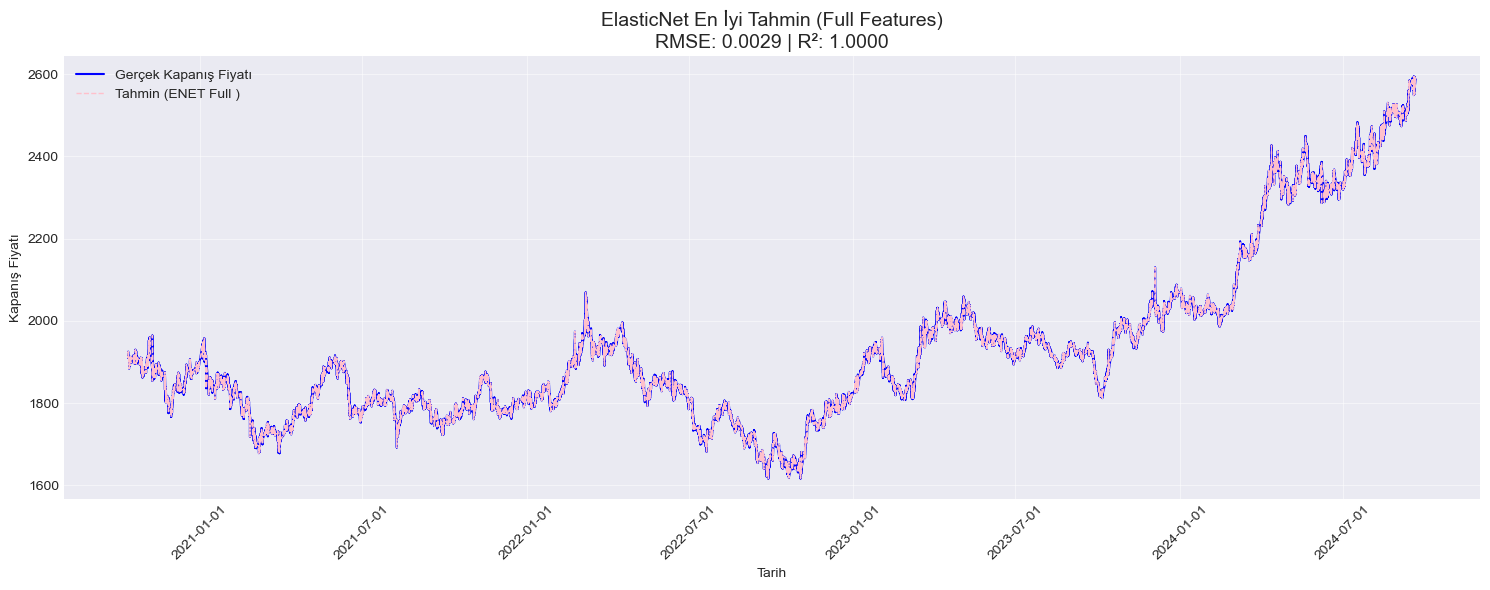

In [372]:
#Görselleştirme: en iyi tahminin zaman serisi grafiği
y_pred_enet = pd.Series(best_enet['Pred'], index=y_test.index)

plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test.values, color='blue', linewidth=1.5, label='Gerçek Kapanış Fiyatı')
plt.plot(y_pred_enet.index, y_pred_enet.values, color='pink', linewidth=1, linestyle='--', label=f"Tahmin (ENET {best_enet['Model']} )")

title_enet = f"ElasticNet En İyi Tahmin ({best_enet['Model']} Features)\nRMSE: {best_enet['RMSE']:.4f} | R²: {best_enet['R2']:.4f}"
plt.title(title_enet, fontsize=14)
plt.xlabel("Tarih"); plt.ylabel("Kapanış Fiyatı"); plt.legend(loc='upper left'); plt.grid(True, alpha=0.5)
plt.tick_params(axis='x', rotation=45); plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.tight_layout()
plt.show()

In [373]:
#7.Model eğitimi ve karşılaştırma sgdregressor
#Modelleri eğitme ve metrikleri hesaplama 
results_sgd = []
SGD_MAX_ITER = 2000
SGD_TOL = 1e-3

In [374]:
#1.FULL features
sgd_full = SGDRegressor(max_iter=SGD_MAX_ITER, tol=SGD_TOL, learning_rate='adaptive', random_state=42)
sgd_full.fit(X_train_scaled_df, y_train)
y_pred_sgd_full = sgd_full.predict(X_test_scaled_df)
rmse_sgd_full = np.sqrt(mean_squared_error(y_test, y_pred_sgd_full))
r2_sgd_full = r2_score(y_test, y_pred_sgd_full)
results_sgd.append({'Model': 'Full', 'RMSE': rmse_sgd_full, 'R2': r2_sgd_full, 'Pred': y_pred_sgd_full})

In [375]:
#2.PCA features
sgd_pca = SGDRegressor(max_iter=SGD_MAX_ITER, tol=SGD_TOL, learning_rate='adaptive', random_state=42)
sgd_pca.fit(X_train_pca, y_train)
y_pred_sgd_pca = sgd_pca.predict(X_test_pca)
rmse_sgd_pca = np.sqrt(mean_squared_error(y_test, y_pred_sgd_pca))
r2_sgd_pca = r2_score(y_test, y_pred_sgd_pca)
results_sgd.append({'Model': 'PCA', 'RMSE': rmse_sgd_pca, 'R2': r2_sgd_pca, 'Pred': y_pred_sgd_pca})

In [376]:
#3.SFS features
sgd_sfs = SGDRegressor(max_iter=SGD_MAX_ITER, tol=SGD_TOL, learning_rate='adaptive', random_state=42)
sgd_sfs.fit(X_train_sfs, y_train)
y_pred_sgd_sfs = sgd_sfs.predict(X_test_sfs)
rmse_sgd_sfs = np.sqrt(mean_squared_error(y_test, y_pred_sgd_sfs))
r2_sgd_sfs = r2_score(y_test, y_pred_sgd_sfs)
results_sgd.append({'Model': 'SFS', 'RMSE': rmse_sgd_sfs, 'R2': r2_sgd_sfs, 'Pred': y_pred_sgd_sfs})

In [377]:
#Sonuçları tablolama ve en iyi modeli seçme
sgd_metrics_df = pd.DataFrame(results_sgd)
print("--- SGDRegressor Analizi: Full vs. SFS vs. PCA Karşılaştırması ---")
print("--- SGDRegressor Karşılaştırma Sonuçları ---")
print(sgd_metrics_df[['Model', 'RMSE', 'R2']].sort_values(by='RMSE').to_string(index=False))

# en düşük RMSE'ye sahip senaryoyu seçme
best_sgd = sgd_metrics_df.loc[sgd_metrics_df['RMSE'].idxmin()]

--- SGDRegressor Analizi: Full vs. SFS vs. PCA Karşılaştırması ---
--- SGDRegressor Karşılaştırma Sonuçları ---
Model     RMSE       R2
 Full 0.558690 0.999992
  SFS 0.668325 0.999989
  PCA 1.418790 0.999951


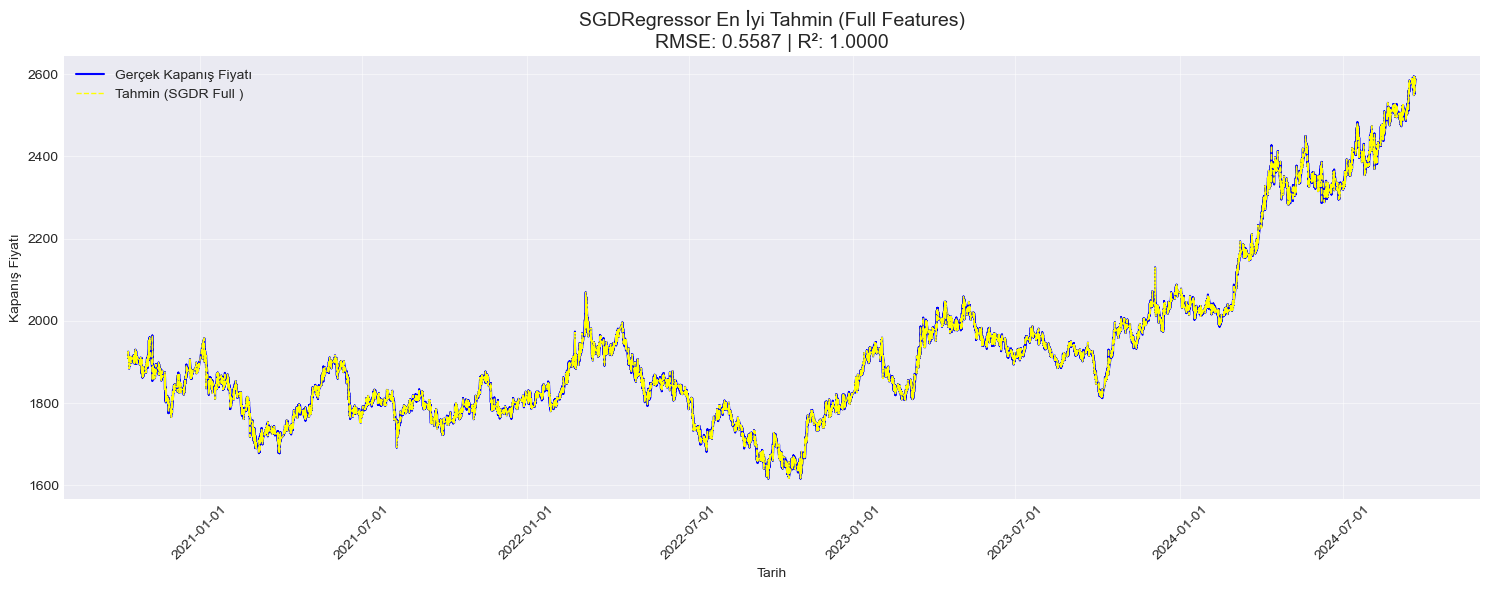

In [378]:
#Görselleştirme: en iyi tahminin zaman serisi grafiği
y_pred_sgd = pd.Series(best_sgd['Pred'], index=y_test.index)

plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test.values, color='blue', linewidth=1.5, label='Gerçek Kapanış Fiyatı')
plt.plot(y_pred_sgd.index, y_pred_sgd.values, color='yellow', linewidth=1, linestyle='--', label=f"Tahmin (SGDR {best_sgd['Model']} )")

title_sgd = f"SGDRegressor En İyi Tahmin ({best_sgd['Model']} Features)\nRMSE: {best_sgd['RMSE']:.4f} | R²: {best_sgd['R2']:.4f}"
plt.title(title_sgd, fontsize=14)
plt.xlabel("Tarih"); plt.ylabel("Kapanış Fiyatı"); plt.legend(loc='upper left'); plt.grid(True, alpha=0.5)
plt.tick_params(axis='x', rotation=45); plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.tight_layout()
plt.show()

In [379]:
# 8.nihai model karşılaştırma ve sonuç (renk isimleriyle güncellendi)
print(" NİHAİ MODEL KARŞILAŞTIRMA VE SONUÇLAR:")

#Hesaplanan metrikleri RMSE ve R2 tek bir DataFramede topluyorum
results = pd.DataFrame({
   'Model_Durum': [
        'ElasticNet (Full)', 'ElasticNet (SFS)', 'ElasticNet (PCA)',
        'SGDRegressor (Full)', 'SGDRegressor (PCA )', 'SGDRegressor (SFS)'
    ],
    'RMSE': [rmse_enet_full, rmse_enet_sfs, rmse_enet_pca,
             rmse_sgd_full, rmse_sgd_pca, rmse_sgd_sfs],
    'R2 Skoru': [r2_enet_full, r2_enet_sfs, r2_enet_pca,
                 r2_sgd_full, r2_sgd_pca, r2_sgd_sfs]
})
# RMSE'ye göre sıralayarak en iyi performansı en üstte gösteriyorum
results_sorted = results.sort_values(by='RMSE', ascending=True).reset_index(drop=True)

print(results_sorted.to_string(index=False))

 NİHAİ MODEL KARŞILAŞTIRMA VE SONUÇLAR:
        Model_Durum     RMSE  R2 Skoru
  ElasticNet (Full) 0.002851  1.000000
   ElasticNet (SFS) 0.052153  1.000000
SGDRegressor (Full) 0.558690  0.999992
 SGDRegressor (SFS) 0.668325  0.999989
   ElasticNet (PCA) 1.418748  0.999951
SGDRegressor (PCA ) 1.418790  0.999951


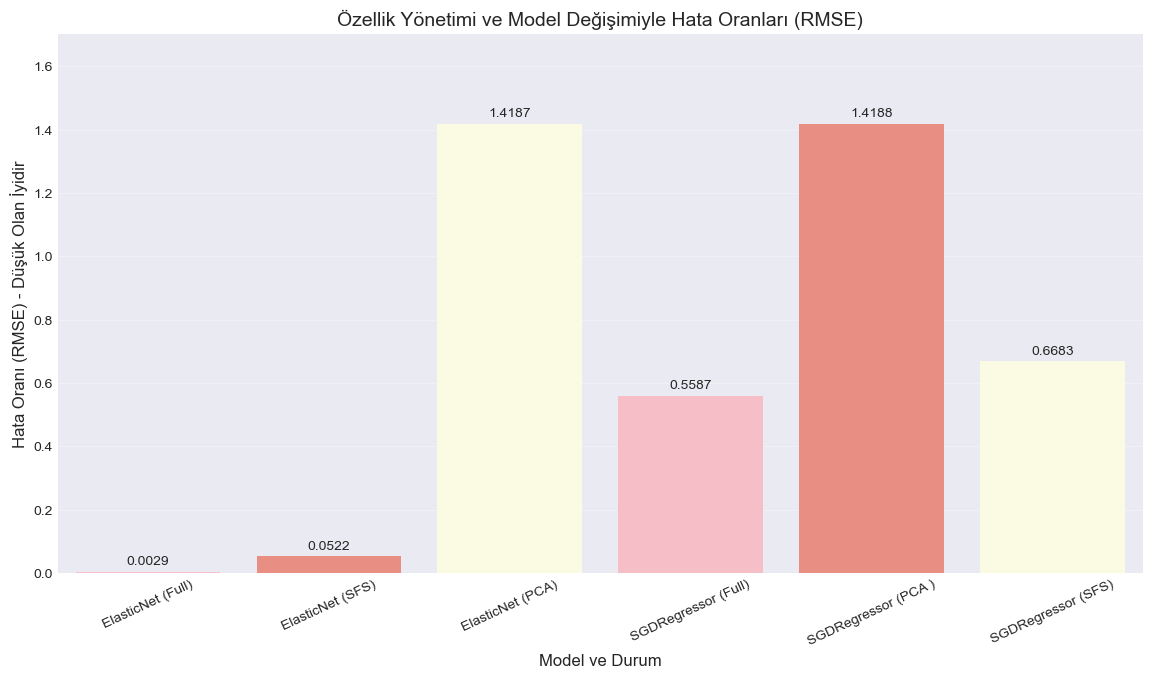

In [380]:
#Görselleştirme
plt.figure(figsize=(14, 7))

# Özelleştirilmiş renkler:
ozel_renkler = [
    'lightpink', 'salmon', 'lightyellow', ]

# RMSE sütunu kullanılarak çubuk grafik oluşturma
bar_plot = sns.barplot(x='Model_Durum', y='RMSE', data=results, palette=ozel_renkler)

plt.title('Özellik Yönetimi ve Model Değişimiyle Hata Oranları (RMSE)', fontsize=14)
plt.ylabel('Hata Oranı (RMSE) - Düşük Olan İyidir', fontsize=12)
plt.xlabel('Model ve Durum', fontsize=12)

# Değerleri çubukların üzerine yazma
for container in bar_plot.containers:
    plt.bar_label(container, fmt='%.4f', padding=3)

plt.ylim(0, max(results['RMSE']) * 1.2)
plt.xticks(rotation=25)
plt.grid(True, axis='y', alpha=0.3)
plt.show()